In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Load Data
def load_data():
    """Load all input files."""
    customers = pd.read_csv(r"C:\Users\HP\Downloads\Customers.csv")
    products = pd.read_csv(r"C:\Users\HP\Downloads\Products.csv")
    transactions = pd.read_csv(r"C:\Users\HP\Downloads\Transactions.csv")
    return customers, products, transactions

customers, products, transactions = load_data()

# Preview Data
print(customers.head())
print(products.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def build_lookalike_model(customers_csv, transactions_csv, products_csv):
    # Step 1: Load and Clean Data
    customers = pd.read_csv(customers_csv)
    transactions = pd.read_csv(transactions_csv)
    products = pd.read_csv(products_csv)

    # Ensure column names are clean
    customers.columns = customers.columns.str.strip()
    transactions.columns = transactions.columns.str.strip()
    products.columns = products.columns.str.strip()

    # Step 2: Merge DataFrames
    merged_data = transactions.merge(customers, on='CustomerID', how='inner')\
                              .merge(products, on='ProductID', how='inner')

    # Rename columns for clarity (optional)
    merged_data.rename(columns={'Price_x': 'TransactionPrice', 'Price_y': 'ProductPrice'}, inplace=True)

    print("\nMerged Data Shape:", merged_data.shape)
    print("\nMerged Data Preview:\n", merged_data.head())

    # Step 3: Feature Engineering - Aggregate customer transaction data
    customer_profiles = merged_data.groupby('CustomerID').agg({
        'TotalValue': 'sum',         # Total spending
        'Quantity': 'sum',           # Total items purchased
        'TransactionPrice': 'mean'   # Average price of transactions
    }).reset_index()

    print("\nCustomer Profiles:\n", customer_profiles.head())

    # Step 4: Normalize Features for Similarity
    features = customer_profiles.drop(columns=['CustomerID'])
    features = (features - features.min()) / (features.max() - features.min())  # Min-max normalization

    # Step 5: Compute Cosine Similarity Matrix
    similarity_matrix = cosine_similarity(features)

    # Step 6: Generate Lookalikes for the first 20 customers
    lookalikes = {}
    for i, cust_id in enumerate(customer_profiles['CustomerID'][:20]):  # Limit to first 20 customers
        similar_indices = np.argsort(similarity_matrix[i])[::-1][1:4]  # Top 3 excluding self
        lookalikes[cust_id] = [
            (customer_profiles['CustomerID'].iloc[j], similarity_matrix[i][j]) for j in similar_indices
        ]

    # Step 7: Save Lookalikes to CSV
    lookalike_list = [
        {'CustomerID': cust_id, 'Lookalikes': lookalikes[cust_id]}
        for cust_id in lookalikes
    ]
    lookalike_df = pd.DataFrame(lookalike_list)
    lookalike_df.to_csv('Lookalike.csv', index=False)

    print("Lookalike.csv generated successfully.")
    return lookalikes

# Example Usage
customers_csv = r"C:\Users\HP\Downloads\Customers.csv"
products_csv = r"C:\Users\HP\Downloads\Products.csv"
transactions_csv = r"C:\Users\HP\Downloads\Transactions.csv"

# Build the Lookalike Model
lookalikes = build_lookalike_model(customers_csv, transactions_csv, products_csv)



Merged Data Shape: (1000, 13)

Merged Data Preview:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  TransactionPrice     CustomerName         Region  SignupDate  \
0      300.68            300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68            300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68            300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36            300.68  Travis Campbell  South America  2024-04-11   
4      902.04            300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Categ

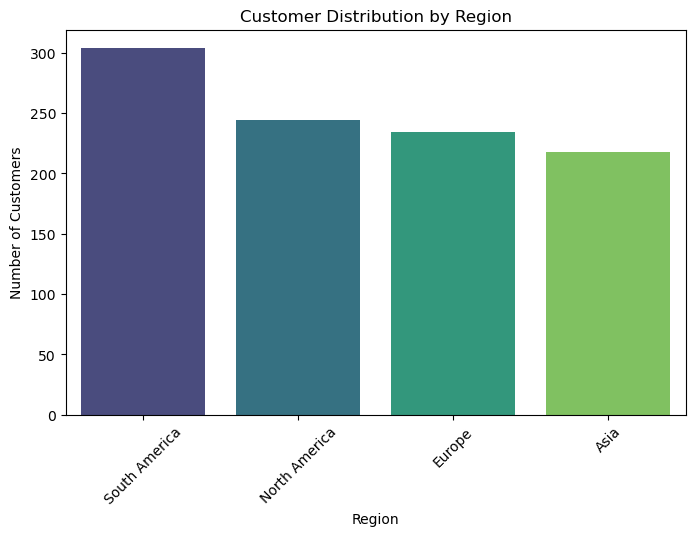

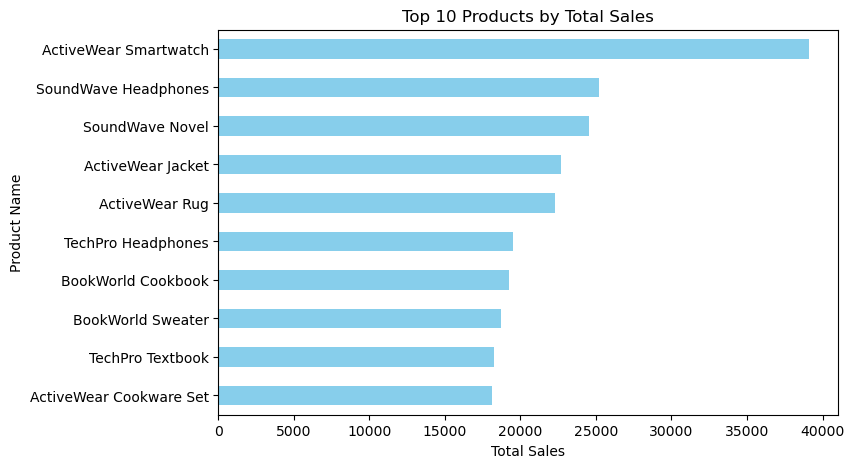

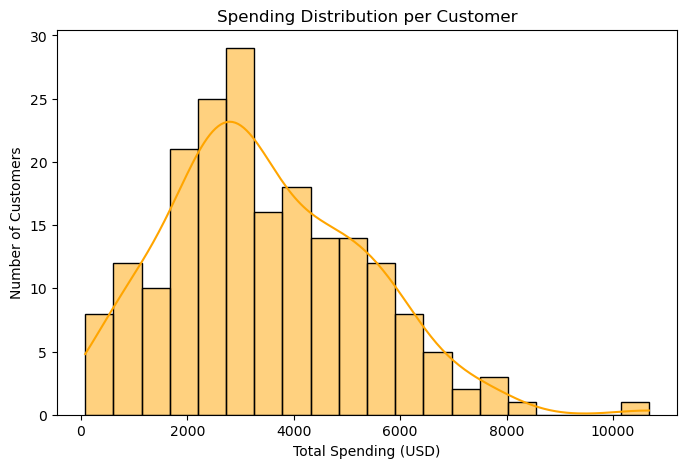

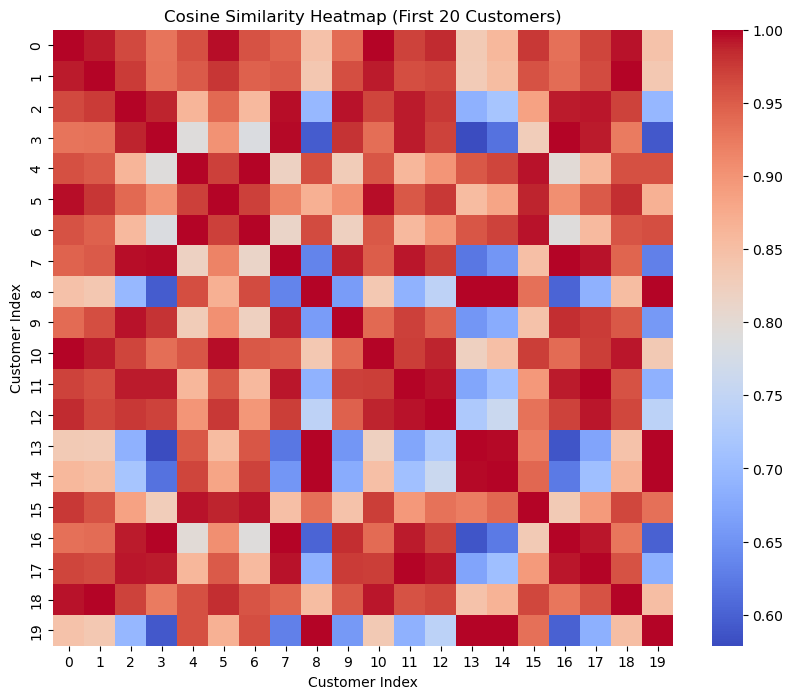

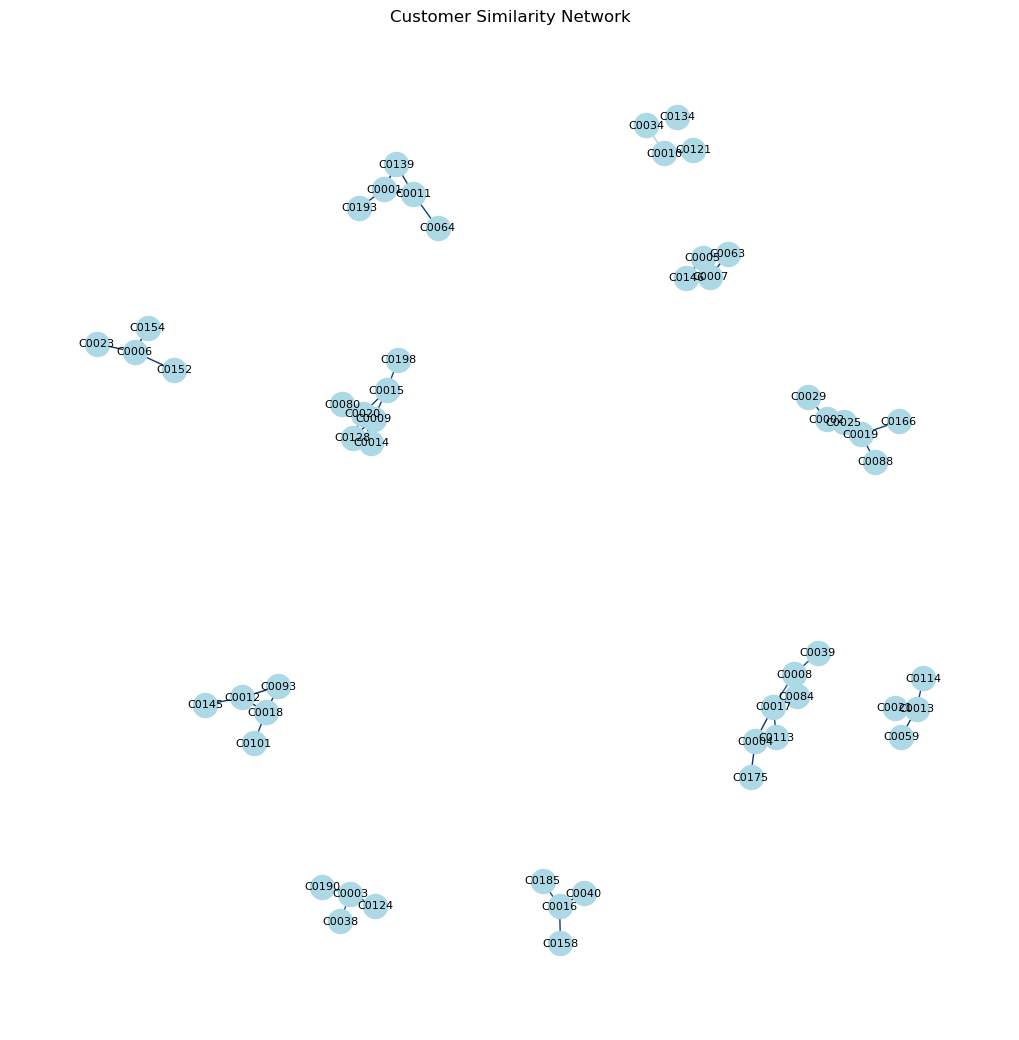

Lookalike.csv generated successfully.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def build_lookalike_model(customers_csv, transactions_csv, products_csv):
    # Step 1: Load and Clean Data
    customers = pd.read_csv(customers_csv)
    transactions = pd.read_csv(transactions_csv)
    products = pd.read_csv(products_csv)

    customers.columns = customers.columns.str.strip()
    transactions.columns = transactions.columns.str.strip()
    products.columns = products.columns.str.strip()

    # Step 2: Merge DataFrames
    merged_data = transactions.merge(customers, on='CustomerID', how='inner')\
                              .merge(products, on='ProductID', how='inner')

    merged_data.rename(columns={'Price_x': 'TransactionPrice', 'Price_y': 'ProductPrice'}, inplace=True)

    # Step 3: Feature Engineering - Aggregate customer transaction data
    customer_profiles = merged_data.groupby('CustomerID').agg({
        'TotalValue': 'sum',
        'Quantity': 'sum',
        'TransactionPrice': 'mean'
    }).reset_index()

    # Visualization 1: Customer Distribution by Region
    plt.figure(figsize=(8, 5))
    region_counts = merged_data['Region'].value_counts()
    sns.barplot(x=region_counts.index, y=region_counts.values, palette="viridis")
    plt.title("Customer Distribution by Region")
    plt.xlabel("Region")
    plt.ylabel("Number of Customers")
    plt.xticks(rotation=45)
    plt.show()

    # Visualization 2: Top Products by Total Sales
    plt.figure(figsize=(8, 5))
    top_products = merged_data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(10)
    top_products.plot(kind='barh', color='skyblue')
    plt.title("Top 10 Products by Total Sales")
    plt.xlabel("Total Sales")
    plt.ylabel("Product Name")
    plt.gca().invert_yaxis()  # Flip y-axis for better readability
    plt.show()

    # Visualization 3: Spending Distribution per Customer
    plt.figure(figsize=(8, 5))
    sns.histplot(customer_profiles['TotalValue'], bins=20, kde=True, color='orange')
    plt.title("Spending Distribution per Customer")
    plt.xlabel("Total Spending (USD)")
    plt.ylabel("Number of Customers")
    plt.show()

    # Step 4: Normalize Features for Similarity
    features = customer_profiles.drop(columns=['CustomerID'])
    features = (features - features.min()) / (features.max() - features.min())  # Min-max normalization

    # Step 5: Compute Cosine Similarity Matrix
    similarity_matrix = cosine_similarity(features)

    # Visualization 4: Cosine Similarity Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix[:20, :20], annot=False, cmap='coolwarm', cbar=True)
    plt.title("Cosine Similarity Heatmap (First 20 Customers)")
    plt.xlabel("Customer Index")
    plt.ylabel("Customer Index")
    plt.show()

    # Step 6: Generate Lookalikes for the first 20 customers
    lookalikes = {}
    for i, cust_id in enumerate(customer_profiles['CustomerID'][:20]):
        similar_indices = np.argsort(similarity_matrix[i])[::-1][1:4]  # Top 3 excluding self
        lookalikes[cust_id] = [
            (customer_profiles['CustomerID'].iloc[j], similarity_matrix[i][j]) for j in similar_indices
        ]

    # Visualization 5: Network Graph for Top Similar Customers
    try:
        import networkx as nx
        G = nx.Graph()
        for cust_id, similar in lookalikes.items():
            for sim_cust_id, score in similar:
                G.add_edge(cust_id, sim_cust_id, weight=score)

        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(G, seed=42)
        edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=weights, edge_cmap=plt.cm.Blues, font_size=8)
        plt.title("Customer Similarity Network")
        plt.show()
    except ImportError:
        print("NetworkX not installed. Skipping network graph visualization.")

    # Step 7: Save Lookalikes to CSV
    lookalike_list = [
        {'CustomerID': cust_id, 'Lookalikes': lookalikes[cust_id]}
        for cust_id in lookalikes
    ]
    lookalike_df = pd.DataFrame(lookalike_list)
    lookalike_df.to_csv('Lookalike.csv', index=False)

    print("Lookalike.csv generated successfully.")
    return lookalikes

# Example Usage
customers_csv = r"C:\Users\HP\Downloads\Customers.csv"
products_csv = r"C:\Users\HP\Downloads\Products.csv"
transactions_csv = r"C:\Users\HP\Downloads\Transactions.csv"

# Build the Lookalike Model
lookalikes = build_lookalike_model(customers_csv, transactions_csv, products_csv)
